# Model Update

### Description

Model Update is the part of syncing the layout and stochastic distribution parameters of the system. Model update has two types.
1. **Logic update** - Updating the layout and logic of the system (.json file of the digital model). It is done by regenerating the digital model using **model generation** techniques.
2. **Input update** - Updating the stochastic parameters of the system such as stochastic processing time. The stochastic processing parameters are calculated per machine using the history of processing times **(Xr)** available in the real_log.

## Input update

##### Assumption
We assume that processing time distribution is an inherent property of the machine, independent of its environment.

##### Assumption:
We assume that the dataset is made of only one distribution set. For cases of mixture of distributions, there are several types of mixture models, such as the Gaussian mixture model (GMM) and the finite mixture model (FMM), each with their own strengths and limitations. Mixture models can be a powerful tool for analyzing datasets with minimal data points and complex underlying distributions, but their application requires a solid understanding of statistical modeling and estimation techniques.

##### Available test methods
1. Kolmogorov-Smirnov test (sensitive to differences in the tails of the distribution)
2. Anderson-Darling test (sensitive to differences in the centre of the distribution)
3. maximum likelihood estimation (for parameters estimation with a know distribution type)
4. kernel density estimation (for PDF without knowing the distribution type)
5. Shapiro-Wilk test for normal distribution (small dataset)

##### Datasets below 30 data points can be considered as a small sample size.
Some academic sources that discuss sample size and statistical tests for determining the distribution of a dataset:

1. Everitt, B. S. (2002). The Cambridge Dictionary of Statistics. Cambridge University Press.
2. Wilcox, R. R. (2017). Introduction to robust estimation and hypothesis testing. Academic Press.
3. Harwell, M. R., Stone, C. A., & Hsu, T. C. (1996). Sample size planning for statistical power and accuracy in parameter estimation. Boca Raton: CRC Press.
4. McDonald, J. H. (2014). Handbook of Biological Statistics. Sparky House Publishing.
5. NIST/SEMATECH e-Handbook of Statistical Methods, http://www.itl.nist.gov/div898/handbook/, accessed on January 11, 2023.

It is important to note that these sources provide general guidelines and that the appropriate sample size and statistical test should be chosen based on the specific research question and context.

##### The assumptions and limitations of the Kolmogorov-Smirnov (KS) test and Anderson-Darling (AD) test are:

1. The KS test assumes that the distribution being tested is continuous, while the AD test can be used for both continuous and discrete distributions.
2. The AD test is known to be more powerful than the KS test for identifying deviations from the hypothesized distribution in the tails of the distribution, but the KS test is more sensitive to differences in the center of the distribution.
3. Both tests assume that the sample data is independent and identically distributed.
4. Both tests assume that the sample data is a random sample from the population being tested.
5. KS test assumes that the data is independent and identically distributed (iid), and that the distribution being tested is fully specified (i.e. all parameters are known).
6. The AD test could be done only for following distributions: 'norm', 'expon', 'gumbel_l', 'gumbel_r', 'logistic'. Hence, we use only KS test.

The choice of which test to use depends on the specific context of the analysis and the distribution being tested. In general, it is recommended to use both tests and compare their results to gain a better understanding of the distribution being tested.

### Main function for input update

In [169]:
import numpy as np
import scipy.stats
import warnings
import matplotlib.pyplot as plt

#--- input update function using kolmogrov-smirnov (ks) test
def input_update(data,dist=None):
    #-- distributions list we are interested in.
    distribution_types_list = ['norm', 'expon']
    # distribution_types_list = ['norm', 'expon', 'gamma','erlang','weibull_min','weibull_max','triang','lognorm','beta']
    distribution_index = len(distribution_types_list)

    #-- initialte variables
    ks_result = np.zeros((distribution_index,2))
    parameters = [0 for _ in range(distribution_index)]

    #-- loop for fitting and testing all the distribution in the list
    for ii in range(distribution_index):
        #--- fit the distribution type to the data
        distribution = distribution_types_list[ii]
        
        warnings.filterwarnings("ignore", category=RuntimeWarning)  # we ignore RuntimeWarning

        parameters[ii] = list(getattr(scipy.stats, distribution).fit(data))
        
        #--- calculate the KS test statistic and p-value
        #-- Pick the distribution with the best p-value close to 1. p-value above 0.95 can be considered good.
        ks_result[ii,0], ks_result[ii,1] = scipy.stats.kstest(data, distribution, args=parameters[ii])  #-- output is D,p-value

        warnings.filterwarnings("default", category=RuntimeWarning) #-- we reset RuntimeWarning

    ks_best_id = np.argmax(ks_result,axis=0)[1]    #-- find index of best p-value (column index 1)
    ks = [distribution_types_list[ks_best_id], ks_result[ks_best_id,1]]
    
    #-- to print all the test results
    # print("result of ks_test = ",ks_result)
    # print("calculated parameters for each distribution = ", parameters)

    #-- QQ plot
    # plot with parameters of best distrribution
    plt.figure(figsize=(8, 6))
    res = scipy.stats.probplot(data, dist=ks[0], sparams=parameters[ks_best_id], plot=plt)
    plt.title(f"Normal Q-Q Plot with best fit distribution")
    plt.show()

    # plot with parameters of actual distrribution
    if dist != None:
        # plot with parameters of actual distrribution
        plt.figure(figsize=(8, 6))
        res = scipy.stats.probplot(data, dist=dist, sparams=parameters[distribution_types_list.index(dist)], plot=plt)
        plt.title(f"Normal Q-Q Plot with actual distribution")
        plt.show()
    
    # #-- to print selected distribution parameters
    # print(f"Best result is: {ks[0]} distribution with a p-value of {ks[1]:.6f}")
    # print(f"The calculated parameters are {parameters[ks_best_id]}")
    return (ks[0],parameters[ks_best_id])


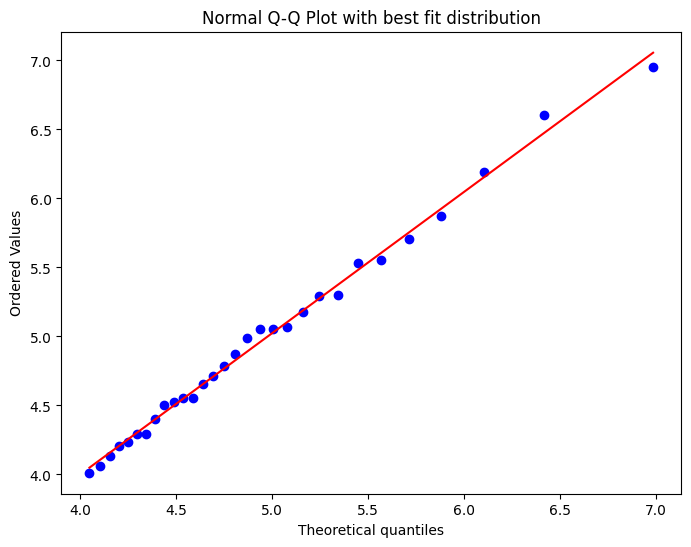

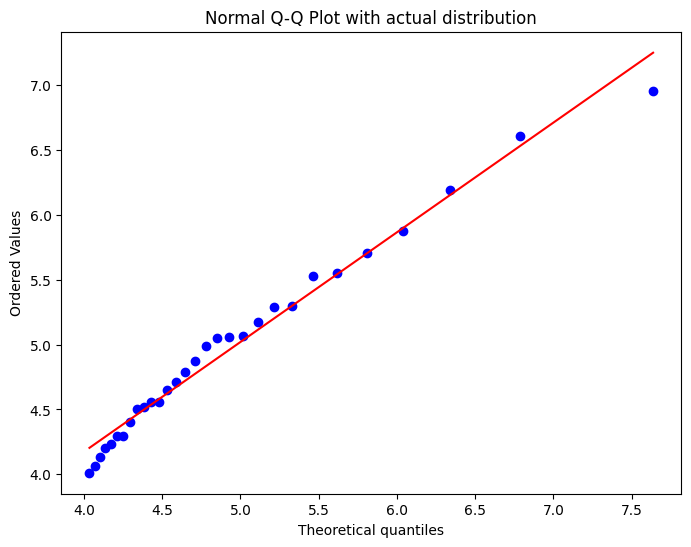

Best result is: weibull_min distribution with a p-value of 0.992424
The calculated parameters are [1.2672953440867227, 3.996423485122007, 1.04634148533923]
identified distribution is : weibull_min and its parameters are : [1.2672953440867227, 3.996423485122007, 1.04634148533923]


In [175]:
#--- use case
size = 30
dist = 'expon'
data = getattr(scipy.stats, dist).rvs(loc=4, size=size)
distribution, parameters = input_update(data,dist)   # if you have a distribution type in mind, pass it to compare the QQ plots using input_update(data,dist)
print(f"identified distribution is : {distribution} and its parameters are : {parameters}")

### Testing Modules

In [129]:
import numpy as np
import scipy.stats
import warnings


In [156]:
# data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# data = np.random.exponential(scale=2, size=5000)
size = 100
dist = 'norm'
data = getattr(scipy.stats, dist).rvs(loc=4, size=size)
distribution_types_list = ['norm', 'expon', 'gamma','erlang','weibull_min','weibull_max','triang','lognorm','beta']
distribution_index = len(distribution_types_list)




In [157]:
ks_result = np.zeros((distribution_index,2))
parameters = [0 for _ in range(distribution_index)]
for ii in range(distribution_index):
    #--- fit the distribution type to the data
    distribution = distribution_types_list[ii]
    
    warnings.filterwarnings("ignore", category=RuntimeWarning)  # we ignore RuntimeWarning

    parameters[ii] = list(getattr(scipy.stats, distribution).fit(data))
    
    #--- calculate the KS test statistic and p-value
    #-- Pick the distribution with the best p-value close to 1. p-value above 0.95 can be considered good.
    ks_result[ii,0], ks_result[ii,1] = scipy.stats.kstest(data, distribution, args=parameters[ii])  #-- output is D,p-value
    # obs_freq, _ = np.histogram(data, bins='auto')
    # exp_freq = getattr(scipy.stats, distribution).cdf(np.histogram(data, bins='auto')[1][1:]) * len(data)
    # chi_stat, chi_pval = scipy.stats.chisquare(obs_freq, exp_freq)

    warnings.filterwarnings("default", category=RuntimeWarning) #-- we reset RuntimeWarning

ks_best_id = np.argmax(ks_result,axis=0)[1]    #-- find index of best p-value (column index 1)
ks = [distribution_types_list[ks_best_id], ks_result[ks_best_id,1]]
print("result of ks_test = ",ks_result,parameters)
print("calculated parameters for each distribution = ", parameters)

print(f"Best result is: {ks[0]} distribution with a p-value of {ks[1]:.6f}")
print(f"The calculated parameters are {parameters[ks_best_id]}")



result of ks_test =  [[6.89829532e-02 7.01752623e-01]
 [3.43937230e-01 4.55888920e-11]
 [7.93381886e-02 5.28852973e-01]
 [7.97067949e-02 5.22919754e-01]
 [5.51394007e-02 9.04796762e-01]
 [6.71769230e-02 7.31787552e-01]
 [1.04681793e-01 2.08048035e-01]
 [7.13127029e-02 6.62523765e-01]
 [5.10599168e-02 9.44804498e-01]] [[4.007405403098763, 1.0318025209102721], [1.0680331162788828, 2.93937228681988], [297.5688452421702, -14.067480273728393, 0.0607079368570487], [234.91160944860383, -12.138024126174734, 0.06868956893564432], [5.375694209774782, -0.8192880505496937, 5.231168597465827], [2.992781556630009, 6.900082500013711, 3.233651586797695], [0.580683625034903, 0.9371441908484885, 5.701245040065664], [0.003302813939139615, -308.2611250302268, 312.2624655484667], [178742058.26911813, 24.55432015872709, -37640822.80683245, 37640831.98412118]]
calculated parameters for each distribution =  [[4.007405403098763, 1.0318025209102721], [1.0680331162788828, 2.93937228681988], [297.5688452421702, -

QQ plot for verification

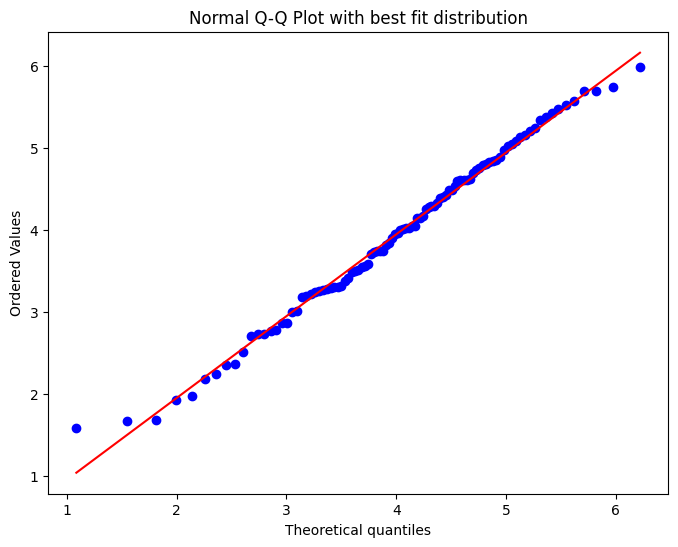

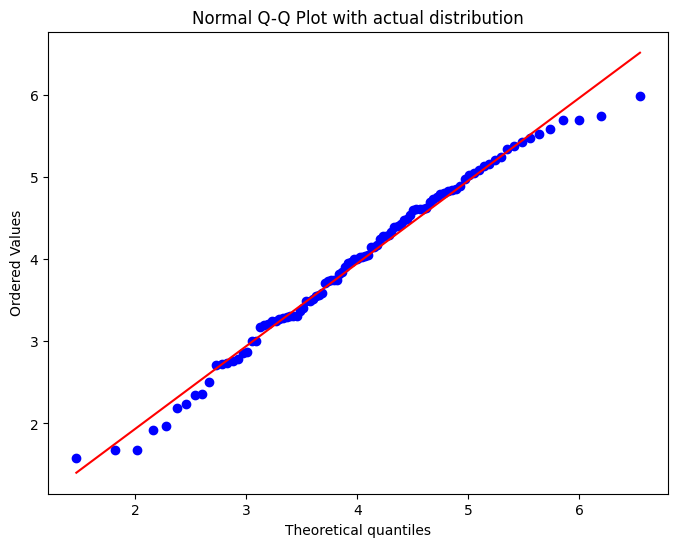

In [168]:
from scipy import stats
import matplotlib.pyplot as plt



plt.figure(figsize=(8, 6))
res = stats.probplot(data, dist=ks[0], sparams=parameters[ks_best_id], plot=plt)
plt.title(f"Normal Q-Q Plot with best fit distribution")
plt.show()

# plot with parameters of actual distrribution
plt.figure(figsize=(8, 6))
res = stats.probplot(data, dist=dist, sparams=parameters[distribution_types_list.index(dist)], plot=plt)
plt.title(f"Normal Q-Q Plot with actual distribution")
plt.show()


In [110]:
print(','.join(map(str, data.tolist())))
type(data
    )

0.5693670191851788,0.8982588668666064,0.39320803763195705,0.713386022766495,1.7594570602628061,7.689301783940496,0.9975958443042174,1.4156821529965598,3.1980284249923017,1.6023416670197754,7.669273321848098,0.11429928131471194,0.880846980932605,1.1385715111704162,0.4445410912954244,0.3693069105475612,0.5436252975932473,2.873768791070564,0.011093191935487077,0.5705822126678188,3.9222596317838847,0.2530560905120853,1.1493682541883334,1.661406787882803,0.4984765187503526,1.166011303751964,1.4153666032959613,0.08669068654148407,0.8620418108804692,2.2902199795627802,0.042498238687728854,0.8538972044712035,0.8598641908993054,3.341906207199554,2.249215345104213,4.227807588378992,1.9061480005495248,1.59340168720698,2.117304227759784,1.546261113534421,4.560774987042666,0.055303282360436065,0.8613524856397393,1.326648005509421,3.6188154853556243,4.685169697440385,0.7962308522198208,0.5594335651076008,0.5208350007866029,4.009142372633367,5.072257283919011,0.04729221585055792,2.053930446874912,3.8

numpy.ndarray

In [76]:
print(parameters)

(0.9168455611156336, 53.85530426741471, 0.07243771307028725, 576.1510350432119)


#### anderson-darling test

In [70]:
# import scipy.stats as stats

# # Generate some sample data
# data = stats.norm.rvs(loc=0, scale=1, size=1000)

# # Specify the distribution to test against
distribution = 'erlang'

# Perform the Anderson-Darling test
result = scipy.stats.anderson(data, dist=distribution)

# Extract the test statistic and critical values
test_statistic = result.statistic
critical_values = result.critical_values

# Print the results
print('Anderson-Darling test statistic:', test_statistic)
print('Critical values:', critical_values)

# # Determine whether to reject or fail to reject the null hypothesis
# if test_statistic < critical_values[0]:
#     print('Reject null hypothesis at significance level 1%')
# elif test_statistic < critical_values[1]:
#     print('Reject null hypothesis at significance level 5%')
# elif test_statistic < critical_values[2]:
#     print('Reject null hypothesis at significance level 10%')
# else:
#     print('Fail to reject null hypothesis')


ValueError: Invalid distribution; dist must be in {'gumbel_r', 'expon', 'norm', 'gumbel_l', 'logistic'}.